# TASK 2: Wavelet Decomposition
Transform spatial image to frequency domain using wavelet transformation on Haar Coefficient

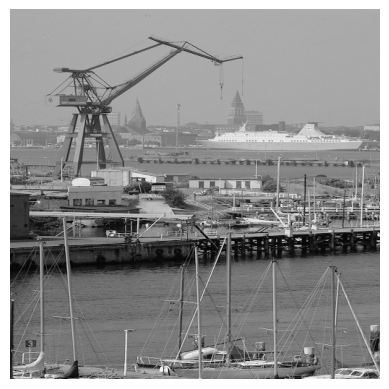

In [ ]:
# Load image
im = read_pgm("./Dataset/kiel.pgm")
show_image_greyscale(im)

In [ ]:
# Image Utility function
def show_images_4_grids(LL, LH, HL, HH, level, wording="Wavelet transformation Level"):
    titles = ['Approximation', ' Horizontal detail', 'Vertical detail', 'Diagonal detail']
    fig = plt.figure(figsize=(8, 8))
    for i, a in enumerate([LL, LH, HL, HH]):
        ax = fig.add_subplot(2, 2, i + 1)
        ax.imshow(a, cmap=plt.cm.gray)
        ax.set_title(titles[i], fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])
    
    fig.tight_layout()
    fig.text(0.37, 1, f"{wording} {level}")
    plt.show()

## Forward and Inverse Wavelet Transform

In [ ]:
def downsample_cols(matrix):
    """
    Input: 2D array
    Output: return 2D array with only the even columns in the input matrix

    Example
    Input: array([[1, 2, 3],
                  [4, 5, 6]])

    Output: array([[1, 3],
                   [4, 6]])
    """
    return matrix[:, ::2]

def downsample_rows(matrix):
    """
    Input: 2D array
    Output: return 2D array with only the even rows in the input matrix

    Example
    Input: array([[1, 2, 3],
                  [4, 5, 6],
                  [7, 8, 9]])
                  
    Output: array([[1, 2, 3],
                   [7, 8, 9]])
    """
    return matrix[::2, :]

def upsample_rows(matrix):
    """
    Input: 2D array
    Output: return 2D arrays with rows of zeroes inserting on top, between, and bottom of the input matrix

    Example
    Input: array([[1, 2, 3],
                  [4, 5, 6],
                  [7, 8, 9]])
                  
    Output: array([[0., 0., 0.],
                   [1., 2., 3.],
                   [0., 0., 0.],
                   [4., 5., 6.],
                   [0., 0., 0.],
                   [7., 8., 9.],
                   [0., 0., 0.]])
    """
    rows, cols = matrix.shape
    upsampled = np.zeros(((2 * rows) + 1, cols))
    upsampled[1::2, :] = matrix  # Put matrix values in odd indices (1,3,5...)
    return upsampled


def upsample_cols(matrix):
    """
    Input: 2D array
    Output: return 2D arrays with columns of 0 inserting on left-most, right-most, and between the input matrix

    Example
    Input: array([[1, 2, 3],
                  [4, 5, 6],
                  [7, 8, 9]])
                  
    Output: array([[0., 0., 0.],
                   [1., 2., 3.],
                   [0., 0., 0.],
                   [4., 5., 6.],
                   [0., 0., 0.],
                   [7., 8., 9.],
                   [0., 0., 0.]])
    """
    rows, cols = matrix.shape
    upsampled = np.zeros((rows, (2 * cols) + 1))
    upsampled[:, 1::2] = matrix

    return upsampled

def convolve_by_column(m, filter):
    """
    Input: 1) matrix 2) filter
    Output: The convolution of filter along each column of the matrix stride by 1
    """
    num_row, num_col = m.shape
    result = np.zeros((num_row - 1, num_col))
    for r in range (num_row):
        for c in range (num_col):
            window = m[r:r+2, c]
            if window.shape[0] != 2:
                break

            result[r, c] = np.dot(filter, window)

    return result

def convolve_by_row(m, filter):
    """
    Input: 1) matrix 2) filter
    Output: The convolution of filter along each row of the matrix stride by 1
    """
    num_row, num_col = m.shape
    result = np.zeros((num_row, num_col - 1))
    for r in range (num_row):
        for c in range (num_col):
            window = m[r, c:c+2]
            if window.shape[0] != 2:
                break

            result[r, c] = np.dot(filter, window)
    return result


def replicate_right_and_bottom_padding(arr):
    """
    Input: 2D array
    Output: 2D array with duplicate right most column and last row
    """
    replicate_all_edges = np.pad(arr, pad_width=1, mode='edge')
    remove_left_and_top_padding = replicate_all_edges[1:, 1:]

    return remove_left_and_top_padding 

def add_frequency(a, b):
    """
    Input: two 2D arrays
    Output: added input arrays. In case, the input shape do not match each other, the bigger input will be cropped to match the smaller one
    """
    if a.shape == b.shape:
        return a + b
    
    diff_in_rows = a.shape[0] - b.shape[0]
    if diff_in_rows > 0:
        a = a[:-diff_in_rows, :]
    elif diff_in_rows < 0:
        b = b[:diff_in_rows, :]

    diff_in_cols = a.shape[1] - b.shape[1]
    if diff_in_cols > 0:
        a = a[:, :-diff_in_cols]
    elif diff_in_cols < 0:
        b = b[:, :diff_in_cols]
    
    return a+b

In [ ]:
def forward_wavelet_transform(im):
    """
    Input: 2D array image
    Output: Forward wavelet transform with haar coefficient on the input
    """
    low_pass_filter = np.array([1, 1]) / np.sqrt(2)
    high_pass_filter = np.array([1, -1]) / np.sqrt(2)

    padded_image = replicate_right_and_bottom_padding(im)

    L = downsample_cols(convolve_by_row(padded_image, low_pass_filter))
    H = downsample_cols(convolve_by_row(padded_image, high_pass_filter))

    LL = downsample_rows(convolve_by_column(L, low_pass_filter))
    LH = downsample_rows(convolve_by_column(L, high_pass_filter))
    HL = downsample_rows(convolve_by_column(H, low_pass_filter))
    HH = downsample_rows(convolve_by_column(H, high_pass_filter))

    return LL, LH, HL, HH

def inverse_wavelet_transform(LL, LH, HL, HH):
    """
    Input: sub-bands of the transformation
    Output: inverse the sub-bands to reconstruct the image
    """
    low_pass_filter = np.array([1, 1]) / np.sqrt(2)
    high_pass_filter = np.array([-1, 1]) / np.sqrt(2)

    reverse_LL = convolve_by_column(upsample_rows(LL), low_pass_filter)
    reverse_LH = convolve_by_column(upsample_rows(LH), high_pass_filter)
    reconstructed_L = add_frequency(reverse_LH, reverse_LL)

    reverse_HL = convolve_by_column(upsample_rows(HL), low_pass_filter)
    reverse_HH = convolve_by_column(upsample_rows(HH), high_pass_filter)
    reconstructed_H = add_frequency(reverse_HH, reverse_HL)

    reconstructed_image = add_frequency(convolve_by_row(upsample_cols(reconstructed_L), low_pass_filter), convolve_by_row(upsample_cols(reconstructed_H), high_pass_filter))

    LL_rows = LL.shape[0]
    LL_cols = LL.shape[1]

    if LL_rows % 2 == 0:
        original_rows = LL_rows*2
    else:
        original_rows = ((LL_rows - 1)*2) + 1
    
    if LL_cols % 2 == 0:
        original_cols = LL_cols*2
    else:
        original_cols = ((LL_cols - 1)*2) + 1

    return reconstructed_image[:original_rows, :original_cols]

In [ ]:
def forward_wavelet_transform_with_level(image, level, show_image=False):
    """
    Input:
      1) Image - to do the wavelet transform
      2) Level - level of transformation
      3) Show image - boolean value on whether to show image or not
    Output: the sub-bands for each level transform
    """
    result = []
    for l in range(1, level+1):
        LL, LH, HL, HH = forward_wavelet_transform(image)
        image = LL
        if show_image:
            show_images_4_grids(LL, LH, HL, HH, l)
        
        result.append(
            {
                "LL": LL, 
                "LH": LH, 
                "HL": HL, 
                "HH": HH
            }
        )
    
    return result

def inverse_wavelet_transform_many_levels(res, show_image=False):
    """
    Construct the image starting from the last_level to get LL of last_level-1, 
    then repeat the step until finally reached the reconstructed original image

    Input: result of each level sub-bands
    Output: the reconsturcted image from sub-bands
    """
    level = len(res)
    reconstructed_im = None
    
    for l in range(level-1, -1, -1):
        LL, LH, HL, HH = res[l]["LL"], res[l]["LH"], res[l]["HL"], res[l]["HH"]
        if not reconstructed_im is None:
            LL = reconstructed_im
        
        if show_image:
            show_images_4_grids(LL, LH, HL, HH, l+1, wording="Inverse wavelet transform level")
        
        reconstructed_im = inverse_wavelet_transform(LL, LH, HL, HH)

    return reconstructed_im
        

## Calculate MSE

In [ ]:
from sklearn.metrics import mean_squared_error

def calculate_mse(original_image, reconstructed_image):
    """
    Input:
      1) Original Image
      2) Reconstructed Image
    Output: Mean square error of the original and reconstructed image
    """
    num_rows, num_cols = original_image.shape
    reconstructed_image = reconstructed_image[:num_rows, :num_cols]

    return mean_squared_error(original_image, reconstructed_image)

## Test Wavelet forward transform 3 level

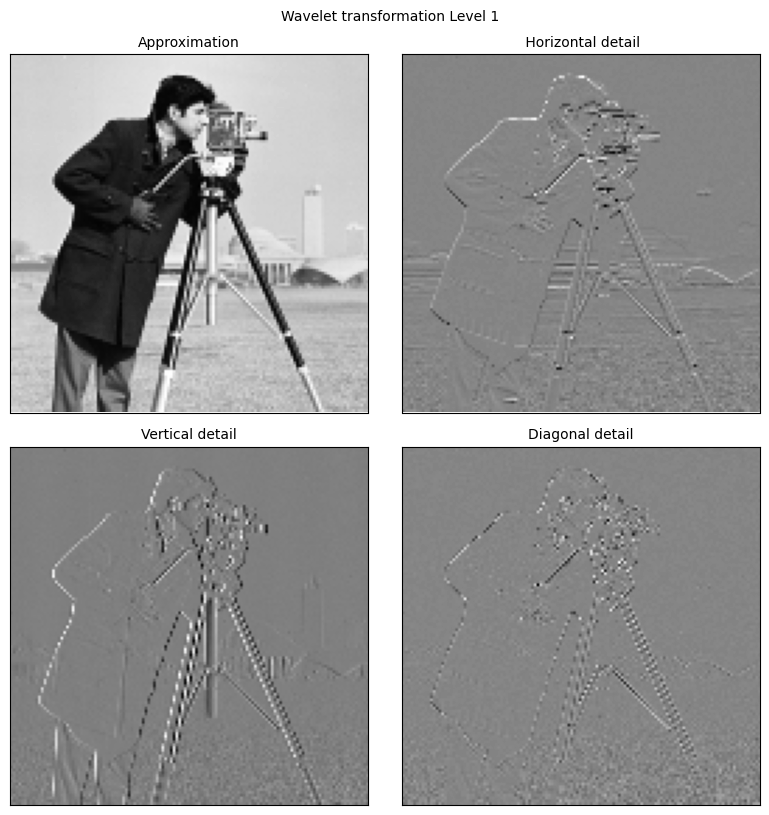

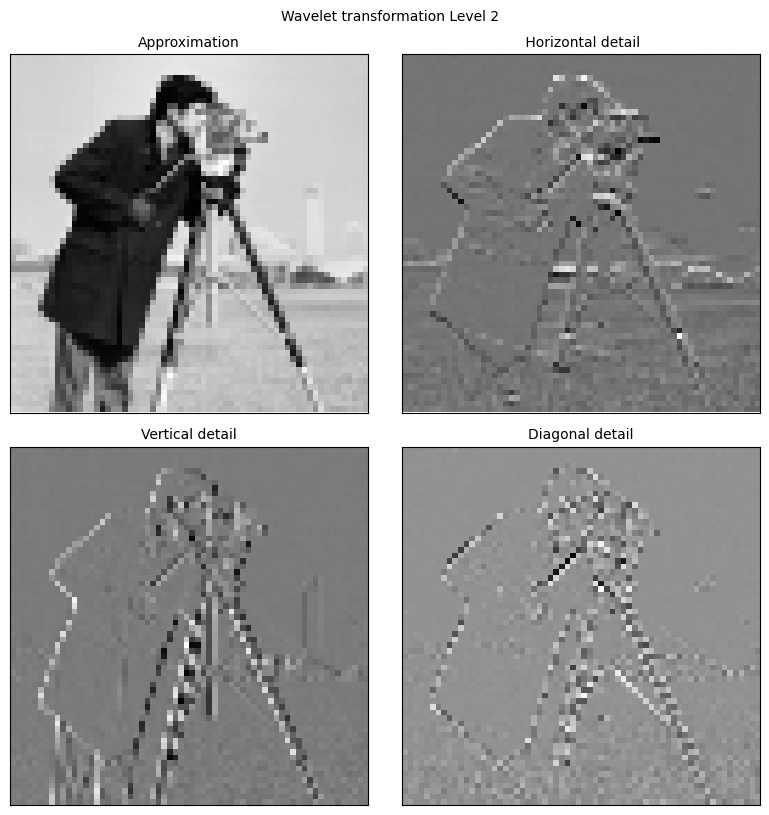

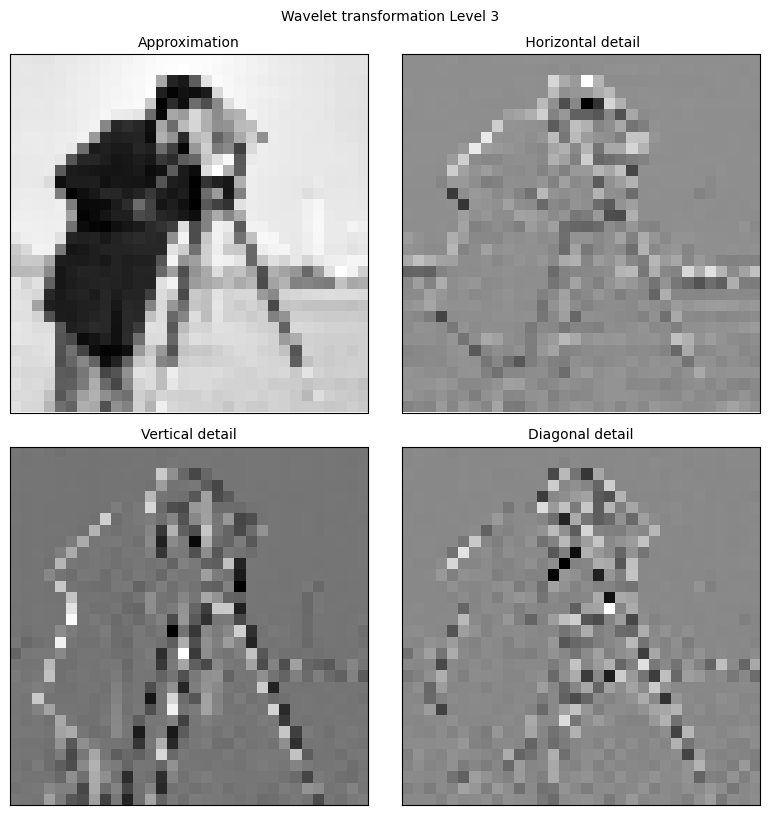

In [ ]:
camera_man_image = read_pgm("./Dataset/cameraman.pgm")

level = 3
show_result = True
res = forward_wavelet_transform_with_level(camera_man_image, level, show_result)

## Test inverse transform

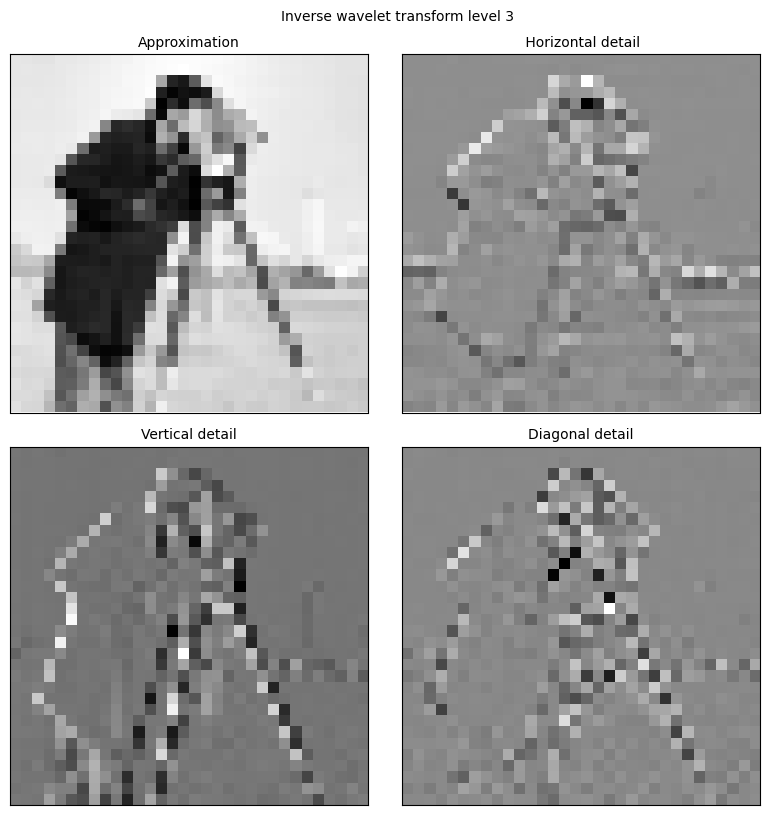

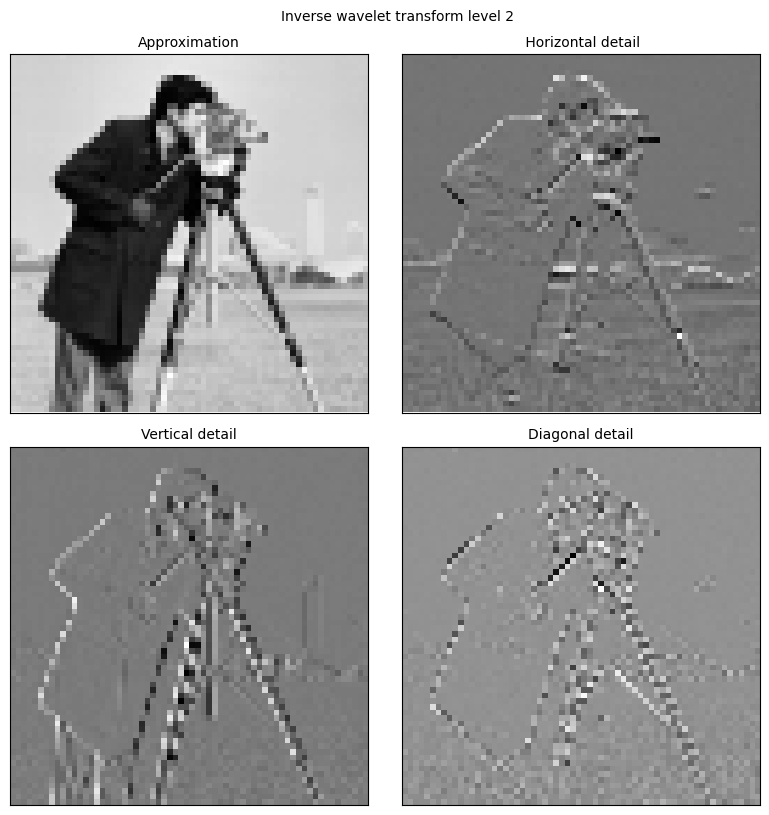

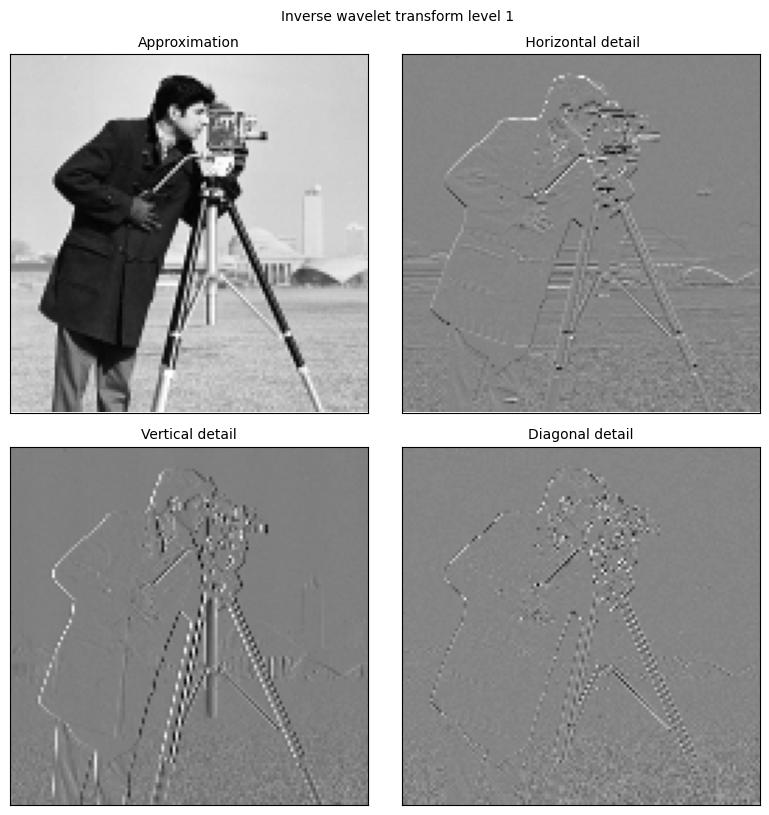

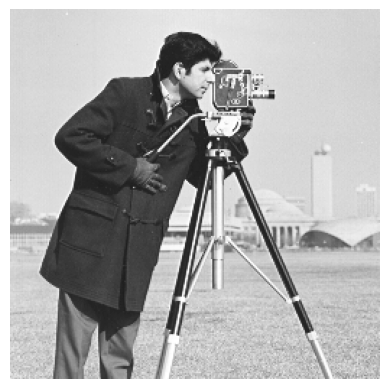

In [ ]:
reconstructed_image = inverse_wavelet_transform_many_levels(res, True)
show_image_greyscale(reconstructed_image)

In [ ]:
camera_man_mse = calculate_mse(camera_man_image, reconstructed_image)
camera_man_mse

np.float64(5.793455587600399e-31)

The MSE of reconstructed image is nearly zero.

## Test calculate MSE

The below code shows the result of MSE after inverse transform on the image in the Dataset folder.

In [ ]:
# Run all image

dataset_directory = './Dataset'
for filename in os.listdir(dataset_directory):
    if filename.endswith(".pgm"):
        file_with_directory = dataset_directory + "/" + filename
        print(file_with_directory)
        im = read_pgm(file_with_directory)

        res = forward_wavelet_transform_with_level(im, 3, False)
        reconstructed_image = inverse_wavelet_transform_many_levels(res)
        mse = calculate_mse(im, reconstructed_image)

        print(f"MSE = {mse}")

./Dataset/man.pgm
MSE = 2.0229964374530204e-31
./Dataset/lungs.pgm
MSE = 6.8569877786461525e-31
./Dataset/clown.pgm
MSE = 1.5556811011268754e-31
./Dataset/clock.pgm
MSE = 6.846055941950291e-31
./Dataset/kiel.pgm
MSE = 3.351491319970985e-31
./Dataset/zelda2.pgm
MSE = 2.4632677549802073e-31
./Dataset/dogbone.pgm
MSE = 1.9252693342154976e-31
./Dataset/truck.pgm
MSE = 2.2125831835131285e-31
./Dataset/couple.pgm
MSE = 2.9873874157689402e-31
./Dataset/mandrill.pgm
MSE = 3.2809291665688787e-31
./Dataset/boats.pgm
MSE = 3.008061710276942e-31
./Dataset/cameraman.pgm
MSE = 5.793455587600399e-31
./Dataset/crowd.pgm
MSE = 1.6853167714483535e-31
./Dataset/girlface.pgm
MSE = 1.7092478123166722e-31
./Dataset/houses.pgm
MSE = 3.6178168816150564e-31
./Dataset/Brain1.pgm
MSE = 1.940750473774708e-31
./Dataset/barbara.pgm
MSE = 2.9844807539967466e-31
./Dataset/lighthouse.pgm
MSE = 2.8936035433332422e-31
./Dataset/bridge.pgm
MSE = 2.810520183684701e-31
